In [1]:
# calculate elapsed time
import time
start_time = time.time()

#### IMPORT

In [2]:
import os, platform
import py7zr

from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

from keras.utils.np_utils import to_categorical 
from tensorflow.keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Dropout, \
    BatchNormalization, Flatten, LSTM
# from scikeras.wrappers import KerasClassifier
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import load_model

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score, auc

from itertools import cycle
from scipy import interp
from scipy.optimize import brentq
from scipy.interpolate import interp1d

#### PARAMETERS
- Set the condition
> * N_FEATURES: Number of Features
> * CHECK_BLANKS: Check for blank data. If any blank data is found, the whole row of data will be deleted.
> * CHECK_CLASS_IMBALANCE: Check for dataset class imbalance. The more balance the dataset, the less biases the model will be.

In [3]:
##############################
# # deep learning features # #
##############################
SEED = 1005 # random seed for reproducibility

# should make this dynamic
N_FEATURES = 644
TIMESTEPS = 1
EPOCH=200
BATCH_SIZE=100

SPLIT_RATIO=0.2

###############
# # preview # #
###############
f = False
t = True

# checking dataset
CHECK_BLANKS = True
CHECK_CLASS_IMBALANCE = True

# evaluate suitable kfold number and kfold model
MIN_KFOLD = 2
MAX_KFOLD = 11
N_KFOLD = 5
EVAL_KFOLD_NUM = False
EVAL_KFOLD_MODEL = False
PERFORM_KFOLD = True

# model testing
TEST_MODEL = True
CON_MATRIX = True
ROC_GRAPH = True

###############
# # dataset # #
###############
CLASSES_COL_NAME = "Subject"
CLASSES_COL_NUM = 0
FEATURES_COL_NUM = 3

# METHOD = "IU"
# METHOD = "DU"

DATASET_DIR_NAME = "dataset\set02\\02_pair"
SAMPLE_DATASET_NAME = "pair_train"
# ACTUAL_DATASET_NAME = "pair_test_" + METHOD

MODEL_DIR_NAME = "dataset\set02\\02_pair"
MODEL_NAME = "model_" + "set02_02_pair"

# RESULT_DIR_NAME = "dataset\set02\\02_pair"
# RESULT_NAME = "result_" + "set02_02_pair_" + METHOD

DATASET_DIR_PATH = os.path.join(os.getcwd(), DATASET_DIR_NAME)
SAMPLE_DATASET_PATH = os.path.join(DATASET_DIR_PATH, SAMPLE_DATASET_NAME + ".csv")
# ACTUAL_DATASET_PATH = os.path.join(DATASET_DIR_PATH, ACTUAL_DATASET_NAME + ".csv")

MODEL_DIR_PATH = os.path.join(os.getcwd(), MODEL_DIR_NAME)
MODEL_PATH = os.path.join(MODEL_DIR_PATH, MODEL_NAME + ".h5")

# RESULT_DIR_PATH = os.path.join(os.getcwd(), RESULT_DIR_NAME)
# RESULT_PATH = os.path.join(RESULT_DIR_PATH, RESULT_NAME + ".csv")

#################
# # sns theme # #
#################
# sns.set_theme(style="darkgrid") # (dark background with white gridlines)
sns.set_theme(style="whitegrid") # (white background with grey gridlines)
# sns.set_theme(style="dark") # (dark background with no gridlines)
# sns.set_theme(style="white") # (white background with no gridlines)
# sns.set_theme(style="ticks") # (white background with axis ticks and no gridlines)

In [4]:
if os.path.isdir(DATASET_DIR_PATH) is True:
    print(f"Dataset directory exists at: {DATASET_DIR_PATH}")
else:
    try:
        os.mkdir(DATASET_DIR_PATH, 666)
        print(f"Dataset directory have been created at: {DATASET_DIR_PATH}")
    except:
        print("Error: Dataset Directory not created")
        
if os.path.isdir(MODEL_DIR_PATH) is True:
    print(f"Model directory exists at: {MODEL_DIR_PATH}")
else:
    try:
        os.mkdir(MODEL_DIR_PATH, 666)
        print(f"Model directory have been created at: {MODEL_DIR_PATH}")
    except:
        print("Error: Model Directory not created")
    
if os.path.exists(SAMPLE_DATASET_PATH) is True:
    print(f"Training dataset exists at: {SAMPLE_DATASET_PATH}")
else:
    try:
        SAMPLE_7Z_PATH = os.path.join(DATASET_DIR_PATH, SAMPLE_DATASET_NAME + ".7z")
        with py7zr.SevenZipFile(SAMPLE_7Z_PATH, mode='r') as z:
            z.extractall(path=DATASET_DIR_PATH)
        print(f"Decompress 7z file to: {SAMPLE_7Z_PATH}")
    except:
        print("Error: Failed to decompress 7z file.")

Dataset directory exists at: C:\Users\andyc\Documents\GitHub\ict4001-cap\dataset\set02\02_pair
Model directory exists at: C:\Users\andyc\Documents\GitHub\ict4001-cap\dataset\set02\02_pair
Decompress 7z file to: C:\Users\andyc\Documents\GitHub\ict4001-cap\dataset\set02\02_pair\pair_train.7z


#### CREATE MODEL
- Create base model
- Wrap it with KerasClassifier

In [5]:
#create base model
def create_base_model():
    model = Sequential()
    model.add(LSTM(units=256, return_sequences=True,
             input_shape=(TIMESTEPS,N_FEATURES)))
    model.add(Dense(256, activation='sigmoid'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(LSTM(units=128, return_sequences=True))
    model.add(Dense(128, activation='sigmoid'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(LSTM(units=64, return_sequences=True))
    model.add(Dense(64, activation='sigmoid'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(LSTM(units=32, return_sequences=True))
    model.add(Dense(32, activation='sigmoid'))
    model.add(Dropout(0.2))

    # softmax for multi-class classification
    model.add(Flatten())
    print("There are a total of " + str(n_classes) + " classes.")
    model.add(Dense(n_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam',
                metrics=['accuracy'])
    return model

# wrap model in KerasClassifier
def create_model():
    model = KerasClassifier(build_fn=create_base_model, epochs=EPOCH, 
                            batch_size=BATCH_SIZE)
    return model

In [6]:
# divide data into features X and target (classes) Y
def prepare_dataset(df):
    X = df.values[:,FEATURES_COL_NUM:].astype(float)
    Y = df.values[:,CLASSES_COL_NUM].astype(str)

    # convert target Y to labelbinarizer Y for model
    # fit_transform is not used to reuse lb
    Y = Y.reshape(-1, 1)
    lb = LabelBinarizer().fit(Y)
    Y = lb.transform(Y)

    #################################
    # # get all the encoded class # #
    #################################
    print("LabelBinarizer is able to decipher: ")
    print(lb.classes_)
    print("\n")

    ###########################
    # # print X and Y shape # #
    ###########################
    print(f"X | Features | Dataset Shape: {X.shape}")
    print(f"Y | Classes  | Dataset Shape: {Y.shape}")

    return X, Y, lb, lb.classes_.tolist()

In [7]:
def split_shape_dataset(X, Y, SPLIT_RATIO, TIMESTEPS, SEED):

    ##############################################################
    # # split dataset into train and test set of 0.8/0.2 ratio # #
    ##############################################################
    X_train, X_test, y_train, y_test = train_test_split(
        X, Y, test_size=SPLIT_RATIO, random_state=SEED)

    ############################
    # # reshaping of dataset # #
    ############################

    # reshaping the dataset to include LSTM Timesteps
    print(X_train.dtype)
    X_train = np.asarray(X_train, dtype=np.float32)
    print(X_train.dtype)
    X_train = np.reshape(X_train, (X_train.shape[0], TIMESTEPS, X_train.shape[1]))
    print(X_test.dtype)
    X_test = np.asarray(X_test, dtype=np.float32)
    print(X_test.dtype)
    X_test = np.reshape(X_test, (X_test.shape[0], TIMESTEPS, X_test.shape[1]))

    print(f"X train shape: {X_train.shape}")
    print(f"Y train shape: {y_train.shape}")
    print(f"X test shape: {X_test.shape}")
    print(f"Y test shape: {y_test.shape}")
    
    return X_train, X_test, y_train, y_test

def reshape_dataset(X, TIMESTEPS):
    # reshaping the dataset to include LSTM Timesteps
    X = np.asarray(X, dtype=np.float32)
    X = np.reshape(X, (X.shape[0], TIMESTEPS, X.shape[1]))
    return X

#### LOAD DATASET

In [8]:
# load dataset
df = pd.read_csv(SAMPLE_DATASET_PATH)
df.head()

,Subject,Seq_No,Sequence,T2-D|0,T2-I|0+1,T2-PF|0+1,T2-RF|0+1,T2-NG|0+1,T2-D|1,T2-I|1+2,...,T9-RF|VAR.1,T9-NG|VAR.1,T9-I|SD.1,T9-PF|SD.1,T9-RF|SD.1,T9-NG|SD.1,T10-I|0+9.1,T10-PF|0+9.1,T10-RF|0+9.1,T10-NG|0+9.1
0,adhy,3,ohm filmed,0.154125,0.093798,0.247924,0.232284,0.38641,0.138486,0.300717,...,0.057276,0.076773,0.190323,0.228078,0.239324,0.277080,1.389586,1.574769,1.505635,1.690818
1,adhy,3,ohm filmed,0.154125,0.093798,0.247924,0.232284,0.38641,0.138486,0.300717,...,0.009492,0.015453,0.104051,0.130934,0.097427,0.124309,1.549967,1.703701,1.713320,1.867054
2,adhy,3,ohm filmed,0.154125,0.093798,0.247924,0.232284,0.38641,0.138486,0.300717,...,0.000120,0.000495,0.010872,0.022351,0.010968,0.022256,1.373775,1.521285,1.489826,1.637336
3,adhy,3,ohm filmed,0.154125,0.093798,0.247924,0.232284,0.38641,0.138486,0.300717,...,0.017052,0.028381,0.103736,0.141618,0.130585,0.168467,1.520914,1.690571,1.599130,1.768788
4,adhy,3,ohm filmed,0.154125,0.093798,0.247924,0.232284,0.38641,0.138486,0.300717,...,0.005920,0.002835,0.039002,0.015306,0.076939,0.053243,1.622926,1.725926,1.722979,1.825979


#### CHECK DATASET

Checking for blanks...
No blank value has been found.
Checking for class imbalance...


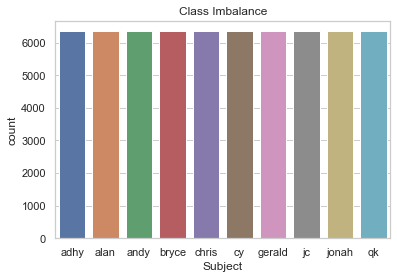

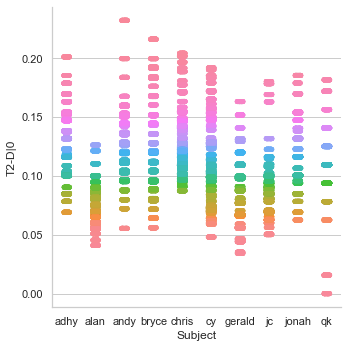

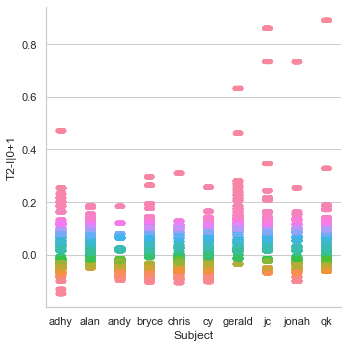

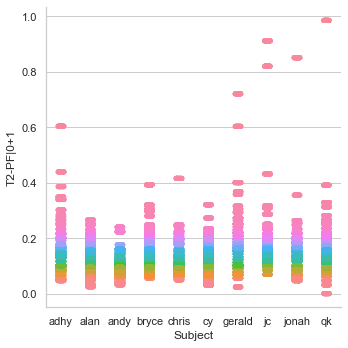

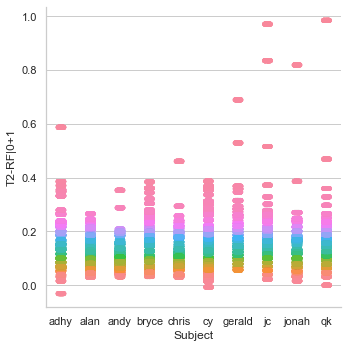

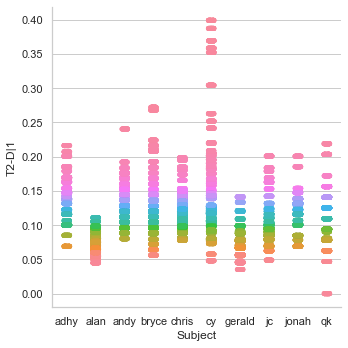

In [9]:
########################
# # check for blanks # #
########################
if CHECK_BLANKS is True:
    # checking for blanks
    print("Checking for blanks...")
    if df.isnull().values.any() is True:
        df = df.dropna(axis=0, how="any")
        print("Blank rows has been dropped.")
    else:
        print("No blank value has been found.")
        
#################################
# # check for class imbalance # #
#################################
if CHECK_CLASS_IMBALANCE is True:
    print("Checking for class imbalance...")
    sns.countplot(x=CLASSES_COL_NAME, data=df).set_title("Class Imbalance")
#     df.loc[(df!=0).any(axis=1)]
    plt.show()

sns.catplot(x="Subject", y="T2-D|0", hue="T2-D|0", data=df, legend=False)
sns.catplot(x="Subject", y="T2-I|0+1", hue="T2-I|0+1", data=df, legend=False)
sns.catplot(x="Subject", y="T2-PF|0+1", hue="T2-PF|0+1", data=df, legend=False)
sns.catplot(x="Subject", y="T2-RF|0+1", hue="T2-RF|0+1", data=df, legend=False)
sns.catplot(x="Subject", y="T2-D|1", hue="T2-D|1", data=df, legend=False)

#### PREPARE DATASET
- Split data based on X / Features and Y / Classes
- Binarize Y into binary labels

In [10]:
X, Y, lb, class_list = prepare_dataset(df)
n_classes = len(class_list)
print(f"Number of Classes: {n_classes}")

LabelBinarizer is able to decipher: 
['adhy' 'alan' 'andy' 'bryce' 'chris' 'cy' 'gerald' 'jc' 'jonah' 'qk']


X | Features | Dataset Shape: (63480, 644)
Y | Classes  | Dataset Shape: (63480, 10)
Number of Classes: 10


#### SPLIT DATASET
- Split dataset into train set and test set 0.8 / 0.2

In [11]:
##############################################################
# # split dataset into train and test set of 0.8/0.2 ratio # #
##############################################################
X_train, X_test, y_train, y_test = split_shape_dataset(X, Y, SPLIT_RATIO, TIMESTEPS, SEED)

float64
float32
float64
float32
X train shape: (50784, 1, 644)
Y train shape: (50784, 10)
X test shape: (12696, 1, 644)
Y test shape: (12696, 10)


#### PERFORM VALIDATION (w KFold Validation)
- Evaluate best KFold Validation
- Generate loss and accuracy graph
- Perform KFold validation

##### Evaluate suitable folds for kfold validation

In [12]:
###############################################
# # evaluate suitable kfold value for model # #
###############################################
def evaluate_kfold(X_train, y_train, SEED, MIN_KFOLD, MAX_KFOLD):
    
    # evaluate the model    
    folds = range(MIN_KFOLD, MAX_KFOLD)
    means, mins, maxs = list(), list(), list()
    
    # evaluate each k value
    for k in folds:
        # define the test condition
        kfold = KFold(n_splits=k, shuffle=True, random_state=SEED)
        
        # evaluate k value
        model = create_model()
        scores = cross_val_score(model, X_train, y_train, cv=kfold, n_jobs=-1)
        
        k_mean = np.mean(scores)
        k_min = scores.min()
        k_max = scores.max()
        
        # report performance
        print(f"No. of Folds: {k} | Accuracy: {k_mean*100:.3f} | Min: {k_min*100:.3f} | Max: {k_max*100:.3f}")
        
        # store mean accuracy and min and max relative to the mean
        means.append(k_mean)
        mins.append(k_mean - k_min)
        maxs.append(k_max - k_mean)
        
    # line plot of k mean values with min/max error bars
    clear_output(wait=True)
    pyplot.errorbar(folds, means, yerr=[mins, maxs], fmt='o')
    
    # show the plot
    pyplot.show()
    
if EVAL_KFOLD_NUM is True:
    evaluate_kfold(X_train, y_train, SEED, MIN_KFOLD, MAX_KFOLD)
else:
    print("EVAL_KFOLD_NUM is not True")

EVAL_KFOLD_NUM is not True


##### Generate kfold validation accuracy and loss

In [13]:
##################################################
# # evaluate kfold model for accuracy and loss # #
##################################################
def evaluate_kfold_model(X_train, y_train, SEED):
    scores, histories = list(), list()
    # create model
    model = create_model()
    # prepare cross validation
    kfold = KFold(n_splits=5, shuffle=True, random_state=SEED)
    # enumerate splits
    for train_ix, test_ix in kfold.split(X_train):
        # select rows for train and test
        trainX, trainY, testX, testY = X_train[train_ix], y_train[train_ix], X_train[test_ix], y_train[test_ix]
        # fit model
        history = model.fit(trainX, trainY, epochs=100, batch_size=50, validation_data=(testX, testY), verbose=0)
        
        # evaluate model
        y_pred = model.predict(testX)
        y_pred = to_categorical(y_pred)

        # evaluate predictions
        acc = accuracy_score(testY, y_pred)
        print("Testing accuracy: %.3f%%" % (acc*100))

        # stores scores and histories
        scores.append(acc)
        histories.append(history)

    for i in range(len(histories)):
        # plot loss
        f1 = plt.figure(1)
        plt.title('Categorical Cross-Entropy Loss')
        plt.plot(histories[i].history['loss'], color='blue')
        plt.plot(histories[i].history['val_loss'], color='orange')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper right')

        # plot accuracy
        f2 = plt.figure(2)
        plt.title('Classification Accuracy')
        plt.plot(histories[i].history['accuracy'], color='blue')
        plt.plot(histories[i].history['val_accuracy'], color='orange')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='lower right')

    # print summary
    print(f"Accuracy | Mean: {np.mean(scores)*100:.3f} | Std: {np.std(scores)*100:.3f} | Length/no.: {len(scores)}")
    # box and whisker plots of results
    f3 = plt.figure(3)
    plt.title('Box and Whisker Plot of Accuracy Scores')
    plt.ylabel('accuracy')
    plt.xlabel('model')
    plt.boxplot(scores)
    clear_output(wait=True)
    plt.show()
    
if EVAL_KFOLD_MODEL is True:
    evaluate_kfold_model(X_train, y_train, SEED)
else:
    print("EVAL_KFOLD_MODEL is not true")

EVAL_KFOLD_MODEL is not true


##### Perform Actual KFold validation

In [14]:
if PERFORM_KFOLD is True:
    # create model
    model = create_model()
    kfold = KFold(n_splits=N_KFOLD, shuffle=True, random_state=SEED)
    valid_score = cross_val_score(model, X_train, y_train, 
                          cv=kfold, error_score="raise", verbose=0)
else:
    print("PERFORM_KFOLD is not true.")

There are a total of 10 classes.
Epoch 1/200
407/407 [==============================] - 13s 18ms/step - loss: 1.9262 - accuracy: 0.2351
Epoch 2/200
407/407 [==============================] - 7s 18ms/step - loss: 1.5295 - accuracy: 0.3508
Epoch 3/200
407/407 [==============================] - 7s 18ms/step - loss: 1.4086 - accuracy: 0.4080
Epoch 4/200
407/407 [==============================] - 7s 17ms/step - loss: 1.3266 - accuracy: 0.4547
Epoch 5/200
407/407 [==============================] - 7s 17ms/step - loss: 1.2221 - accuracy: 0.4939
Epoch 6/200
407/407 [==============================] - 7s 17ms/step - loss: 1.1451 - accuracy: 0.5255
Epoch 7/200
407/407 [==============================] - 7s 17ms/step - loss: 1.0755 - accuracy: 0.5598
Epoch 8/200
407/407 [==============================] - 7s 17ms/step - loss: 1.0460 - accuracy: 0.5886
Epoch 9/200
407/407 [==============================] - 7s 17ms/step - loss: 1.0011 - accuracy: 0.6077
Epoch 10/200
407/407 [==========================

407/407 [==============================] - 7s 18ms/step - loss: 0.3180 - accuracy: 0.8868
Epoch 160/200
407/407 [==============================] - 7s 18ms/step - loss: 0.3112 - accuracy: 0.8894
Epoch 161/200
407/407 [==============================] - 7s 18ms/step - loss: 0.3220 - accuracy: 0.8877
Epoch 162/200
407/407 [==============================] - 7s 18ms/step - loss: 0.3061 - accuracy: 0.8923
Epoch 163/200
407/407 [==============================] - 7s 18ms/step - loss: 0.3023 - accuracy: 0.8930
Epoch 164/200
407/407 [==============================] - 7s 18ms/step - loss: 0.3089 - accuracy: 0.8900
Epoch 165/200
407/407 [==============================] - 7s 18ms/step - loss: 0.3024 - accuracy: 0.8943
Epoch 166/200
407/407 [==============================] - 7s 18ms/step - loss: 0.3059 - accuracy: 0.8915
Epoch 167/200
407/407 [==============================] - 8s 19ms/step - loss: 0.2939 - accuracy: 0.8950
Epoch 168/200
407/407 [==============================] - 8s 19ms/step - loss: 

407/407 [==============================] - 8s 19ms/step - loss: 0.7360 - accuracy: 0.7189
Epoch 38/200
407/407 [==============================] - 8s 19ms/step - loss: 0.7144 - accuracy: 0.7238
Epoch 39/200
407/407 [==============================] - 8s 20ms/step - loss: 0.7288 - accuracy: 0.7197
Epoch 40/200
407/407 [==============================] - 8s 20ms/step - loss: 0.7267 - accuracy: 0.7216
Epoch 41/200
407/407 [==============================] - 8s 20ms/step - loss: 0.7044 - accuracy: 0.7264
Epoch 42/200
407/407 [==============================] - 8s 20ms/step - loss: 0.6972 - accuracy: 0.7341
Epoch 43/200
407/407 [==============================] - 8s 20ms/step - loss: 0.6984 - accuracy: 0.7338
Epoch 44/200
407/407 [==============================] - 8s 20ms/step - loss: 0.7037 - accuracy: 0.7338
Epoch 45/200
407/407 [==============================] - 8s 20ms/step - loss: 0.6809 - accuracy: 0.7394
Epoch 46/200
407/407 [==============================] - 8s 20ms/step - loss: 0.6859 - 

407/407 [==============================] - 8s 20ms/step - loss: 0.2252 - accuracy: 0.9214
Epoch 195/200
407/407 [==============================] - 8s 20ms/step - loss: 0.2310 - accuracy: 0.9211
Epoch 196/200
407/407 [==============================] - 8s 20ms/step - loss: 0.2338 - accuracy: 0.9204
Epoch 197/200
407/407 [==============================] - 8s 20ms/step - loss: 0.2272 - accuracy: 0.9199
Epoch 198/200
407/407 [==============================] - 8s 20ms/step - loss: 0.2230 - accuracy: 0.9238
Epoch 199/200
407/407 [==============================] - 8s 20ms/step - loss: 0.2314 - accuracy: 0.9205
Epoch 200/200
102/102 [==============================] - 2s 8ms/step - loss: 0.2447 - accuracy: 0.9102
There are a total of 10 classes.
Epoch 1/200
407/407 [==============================] - 22s 37ms/step - loss: 2.0010 - accuracy: 0.2186
Epoch 2/200
407/407 [==============================] - 15s 38ms/step - loss: 1.5578 - accuracy: 0.3430
Epoch 3/200
407/407 [===========================

407/407 [==============================] - 13s 32ms/step - loss: 0.3668 - accuracy: 0.8684
Epoch 150/200
407/407 [==============================] - 13s 32ms/step - loss: 0.3813 - accuracy: 0.8643
Epoch 151/200
407/407 [==============================] - 13s 32ms/step - loss: 0.3645 - accuracy: 0.8692
Epoch 152/200
407/407 [==============================] - 13s 32ms/step - loss: 0.3857 - accuracy: 0.8638
Epoch 153/200
407/407 [==============================] - 13s 32ms/step - loss: 0.3679 - accuracy: 0.8664
Epoch 154/200
407/407 [==============================] - 13s 32ms/step - loss: 0.3733 - accuracy: 0.8670
Epoch 155/200
407/407 [==============================] - 13s 32ms/step - loss: 0.4340 - accuracy: 0.8494
Epoch 156/200
407/407 [==============================] - 13s 32ms/step - loss: 0.3796 - accuracy: 0.8640
Epoch 157/200
407/407 [==============================] - 13s 32ms/step - loss: 0.3491 - accuracy: 0.8753
Epoch 158/200
407/407 [==============================] - 13s 32ms/ste

407/407 [==============================] - 13s 33ms/step - loss: 0.3325 - accuracy: 0.8838
Epoch 105/200
407/407 [==============================] - 13s 33ms/step - loss: 0.3215 - accuracy: 0.8847
Epoch 106/200
407/407 [==============================] - 13s 33ms/step - loss: 0.3193 - accuracy: 0.8881
Epoch 107/200
407/407 [==============================] - 13s 33ms/step - loss: 0.3194 - accuracy: 0.8899
Epoch 108/200
407/407 [==============================] - 14s 33ms/step - loss: 0.3146 - accuracy: 0.8883
Epoch 109/200
407/407 [==============================] - 13s 33ms/step - loss: 0.3470 - accuracy: 0.8798
Epoch 110/200
407/407 [==============================] - 14s 33ms/step - loss: 0.3221 - accuracy: 0.8862
Epoch 111/200
407/407 [==============================] - 14s 33ms/step - loss: 0.3033 - accuracy: 0.8940
Epoch 112/200
407/407 [==============================] - 13s 33ms/step - loss: 0.3026 - accuracy: 0.8945
Epoch 113/200
407/407 [==============================] - 13s 33ms/ste

407/407 [==============================] - 15s 37ms/step - loss: 0.6447 - accuracy: 0.7632
Epoch 60/200
407/407 [==============================] - 16s 38ms/step - loss: 0.6364 - accuracy: 0.7671
Epoch 61/200
407/407 [==============================] - 15s 37ms/step - loss: 0.6317 - accuracy: 0.7664
Epoch 62/200
407/407 [==============================] - 16s 39ms/step - loss: 0.6242 - accuracy: 0.7734
Epoch 63/200
407/407 [==============================] - 16s 38ms/step - loss: 0.6150 - accuracy: 0.7758
Epoch 64/200
407/407 [==============================] - 16s 39ms/step - loss: 0.6254 - accuracy: 0.7754
Epoch 65/200
407/407 [==============================] - 16s 39ms/step - loss: 0.6049 - accuracy: 0.7824
Epoch 66/200
407/407 [==============================] - 15s 37ms/step - loss: 0.6102 - accuracy: 0.7812
Epoch 67/200
407/407 [==============================] - 16s 38ms/step - loss: 0.6217 - accuracy: 0.7771
Epoch 68/200
407/407 [==============================] - 16s 39ms/step - loss:

##### Get Validation Accuracy

In [15]:
if PERFORM_KFOLD is True:
    print("Validation Accuracy of %.2f%% (with standard deviation of %.2f%%)" % 
      (valid_score.mean()*100, valid_score.std()*100))
else:
    print("PERFORM_KFOLD is not true.")

Validation Accuracy of 87.21% (with standard deviation of 4.21%)


#### FIT MODEL FOR TESTING
- Fit the Model
- View Accuracy and Loss Graph
- View Model Summary

In [16]:
#####################
# # fit the model # #
#####################

if TEST_MODEL is True:
    model = create_model()
    es = EarlyStopping(monitor='loss', mode='min', min_delta=0.001, patience=50,
                       verbose=1)
    history = model.fit(X_train, y_train, callbacks=es, verbose=1)

There are a total of 10 classes.
Epoch 1/200
508/508 [==============================] - 30s 46ms/step - loss: 1.9059 - accuracy: 0.2509
Epoch 2/200
508/508 [==============================] - 25s 48ms/step - loss: 1.4735 - accuracy: 0.3837
Epoch 3/200
508/508 [==============================] - 23s 46ms/step - loss: 1.3694 - accuracy: 0.4219
Epoch 4/200
508/508 [==============================] - 23s 46ms/step - loss: 1.2747 - accuracy: 0.4557
Epoch 5/200
508/508 [==============================] - 23s 45ms/step - loss: 1.1885 - accuracy: 0.4964
Epoch 6/200
508/508 [==============================] - 22s 44ms/step - loss: 1.1223 - accuracy: 0.5334
Epoch 7/200
508/508 [==============================] - 22s 43ms/step - loss: 1.0700 - accuracy: 0.5656
Epoch 8/200
508/508 [==============================] - 22s 43ms/step - loss: 1.0399 - accuracy: 0.5928
Epoch 9/200
508/508 [==============================] - 22s 42ms/step - loss: 1.0127 - accuracy: 0.6080
Epoch 10/200
508/508 [==================

508/508 [==============================] - 20s 40ms/step - loss: 0.2353 - accuracy: 0.9179
Epoch 158/200
508/508 [==============================] - 21s 41ms/step - loss: 0.2564 - accuracy: 0.9116
Epoch 159/200
508/508 [==============================] - 21s 40ms/step - loss: 0.2401 - accuracy: 0.9169
Epoch 160/200
508/508 [==============================] - 20s 40ms/step - loss: 0.2277 - accuracy: 0.9208
Epoch 161/200
508/508 [==============================] - 21s 41ms/step - loss: 0.2563 - accuracy: 0.9118
Epoch 162/200
508/508 [==============================] - 21s 41ms/step - loss: 0.2300 - accuracy: 0.9184
Epoch 163/200
508/508 [==============================] - 21s 41ms/step - loss: 0.2364 - accuracy: 0.9190
Epoch 164/200
508/508 [==============================] - 21s 41ms/step - loss: 0.2271 - accuracy: 0.9193
Epoch 165/200
508/508 [==============================] - 21s 40ms/step - loss: 0.2404 - accuracy: 0.9174
Epoch 166/200
508/508 [==============================] - 21s 41ms/ste

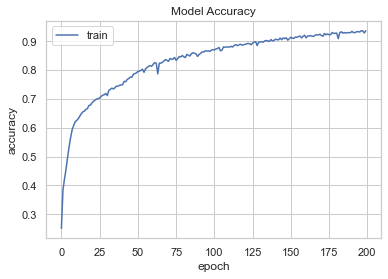

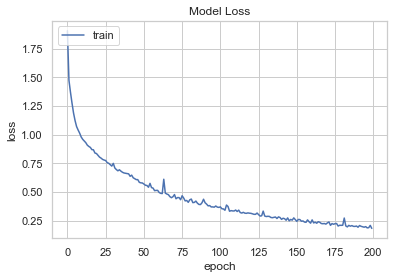

In [17]:
if TEST_MODEL is True:
    ##########################
    # # get model accuracy # #
    ##########################
    plt.plot(history.history['accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train'], loc='upper left')
    plt.show()

    ######################
    # # get model loss # #
    ######################
    plt.plot(history.history['loss'])
    plt.title('Model Loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train'], loc='upper left')
    plt.show()

In [18]:
if TEST_MODEL is True:
    ##########################
    # # view model summary # #
    ##########################
    model.model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_20 (LSTM)              (None, 1, 256)            922624    
                                                                 
 dense_25 (Dense)            (None, 1, 256)            65792     
                                                                 
 dropout_20 (Dropout)        (None, 1, 256)            0         
                                                                 
 batch_normalization_15 (Bat  (None, 1, 256)           1024      
 chNormalization)                                                
                                                                 
 lstm_21 (LSTM)              (None, 1, 128)            197120    
                                                                 
 dense_26 (Dense)            (None, 1, 128)            16512     
                                                      

#### MODEL TESTING
- Get Model Accuracy on the Test Dataset
- Generate Confusion Matrix
- Generate ROC Curves
- Save the Model if Appropriate

In [19]:
if TEST_MODEL is True:
    y_pred = model.predict_proba(X_test)

    # evaluate predictions
    acc = accuracy_score(lb.inverse_transform(y_test), lb.inverse_transform(y_pred))
    print("Testing accuracy: %.3f%%" % (acc*100))

Testing accuracy: 87.831%


##### Confusion Matrix

12696 is the number of test value in kfold_val / train_test_split


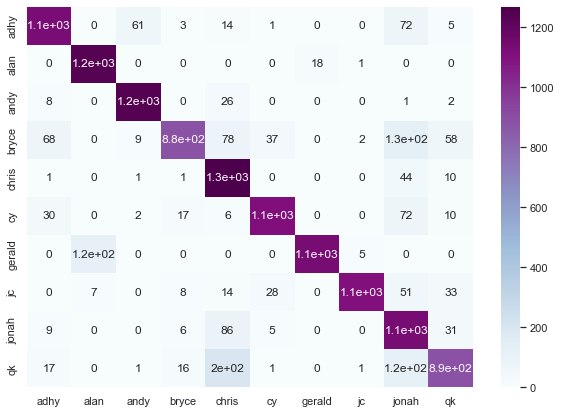

In [20]:
if TEST_MODEL is True and CON_MATRIX is True:
    # confusion matrix
    print(str(len(y_pred)) + " is the number of test value in kfold_val / train_test_split")
    cm = confusion_matrix(lb.inverse_transform(y_test), lb.inverse_transform(y_pred))
    df_cm = pd.DataFrame(cm, index = [i for i in np.unique(lb.inverse_transform(y_test))],
                         columns = [i for i in np.unique(lb.inverse_transform(y_test))])

    plt.figure(figsize = (10,7))
    sns.heatmap(df_cm, annot=True, cmap="BuPu")

##### ROC Curve (Individual)

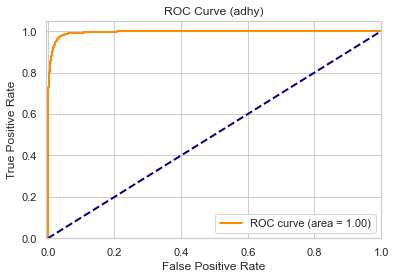

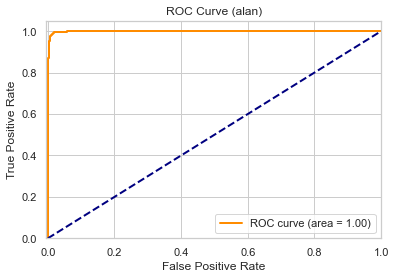

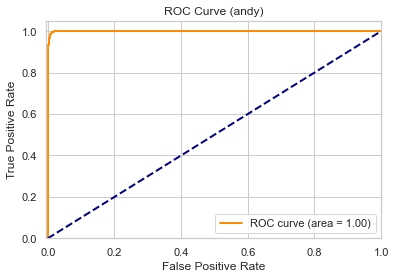

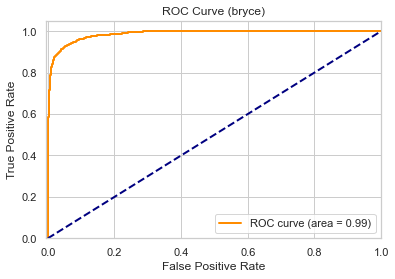

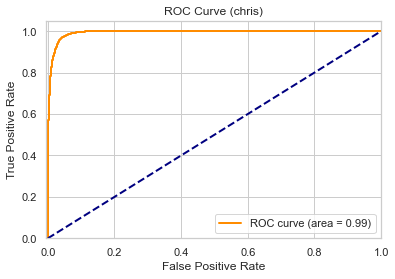

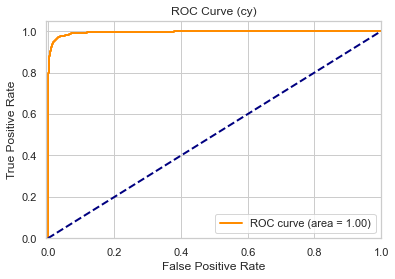

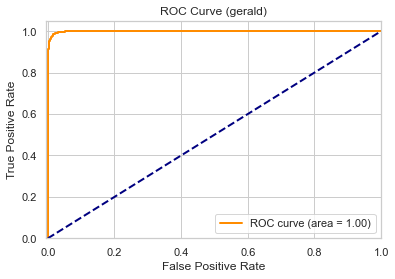

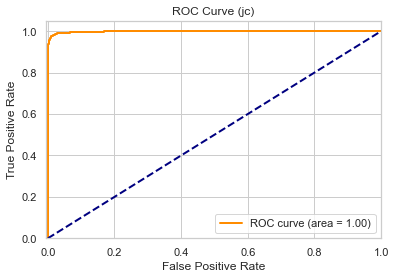

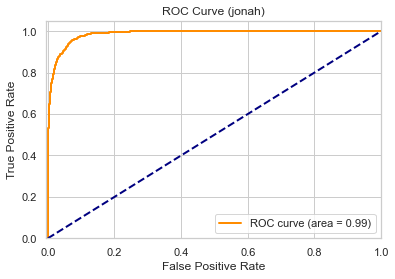

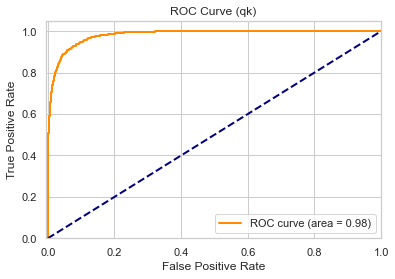

In [21]:
if TEST_MODEL is True and ROC_GRAPH is True: # compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    for i in range(n_classes):
        plt.figure()
        lw = 2
        plt.plot(
            fpr[i],
            tpr[i],
            color="darkorange",
            lw=lw,
            label="ROC curve (area = %0.2f)" % roc_auc[i],
        )
        plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
        plt.xlim([-0.005, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC Curve (" + str(lb.classes_[i]) + ")")
        plt.legend(loc="lower right")
        plt.show()

##### ROC Curve (Multiclass)

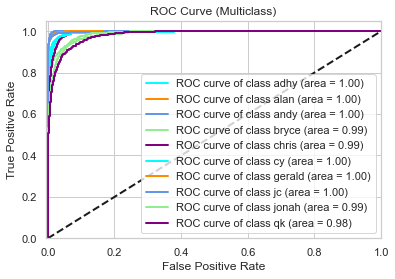

In [22]:
if TEST_MODEL is True and ROC_GRAPH is True:
    # compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], thresholds = roc_curve(y_test.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # first aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    # plt.figure()
    # plt.plot(
    #     fpr["micro"],
    #     tpr["micro"],
    #     label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    #     color="deeppink",
    #     linestyle=":",
    #     linewidth=4,
    # )

    # plt.plot(
    #     fpr["macro"],
    #     tpr["macro"],
    #     label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    #     color="navy",
    #     linestyle=":",
    #     linewidth=4,
    # )

    colors = cycle(["aqua", "darkorange", "cornflowerblue", "lightgreen", "purple"])
    for i, color in zip(range(n_classes), colors):
        plt.plot(
            fpr[i],
            tpr[i],
            color=color,
            lw=lw,
            label="ROC curve of class {0} (area = {1:0.2f})".format(lb.classes_[i], roc_auc[i]),
        )

    plt.plot([0, 1], [0, 1], "k--", lw=lw)
    plt.xlim([-0.005, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve (Multiclass)")
    plt.legend(loc="lower right")
    plt.show()

##### ROC Curve (Average)

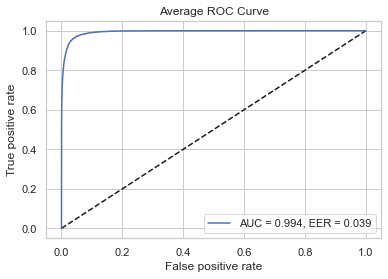

In [23]:
if TEST_MODEL is True and ROC_GRAPH is True:
    fpr, tpr, threshold = roc_curve(y_test.ravel(), y_pred.ravel())

    # calculate equal-error-rate
    eer = brentq(lambda x : 1. - x - interp1d(fpr, tpr)(x), 0., 1.)

    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label='AUC = {:.3f}, EER = {:.3f}'.format(auc(fpr, tpr), eer))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('Average ROC Curve')
    plt.legend(loc='best')
    plt.show()

#### FIT AND SAVE MODEL
- Fitting of model
- Get Accuracy and Loss of Mdoel
- Saving Model

In [24]:
############################
# # reshaping of dataset # #
############################
# loading of dataset
df = pd.read_csv(SAMPLE_DATASET_PATH)

df.head()
dataset = df.values

# divide data into features X and target (classes) Y
# convert target Y to labelbinarizer Y for model
X, Y, lb, class_list = prepare_dataset(df)

# reshaping the dataset to include LSTM Timesteps
X = reshape_dataset(X, TIMESTEPS)
n_classes = Y.shape[1]

#####################
# # fit the model # #
#####################

model = create_model()
es = EarlyStopping(monitor='loss', mode='min', min_delta=0.001, patience=50,
                   verbose=0)
history = model.fit(X, Y, callbacks=es)

LabelBinarizer is able to decipher: 
['adhy' 'alan' 'andy' 'bryce' 'chris' 'cy' 'gerald' 'jc' 'jonah' 'qk']


X | Features | Dataset Shape: (63480, 644)
Y | Classes  | Dataset Shape: (63480, 10)
There are a total of 10 classes.
Epoch 1/200
635/635 [==============================] - 38s 50ms/step - loss: 1.8068 - accuracy: 0.2828
Epoch 2/200
635/635 [==============================] - 30s 48ms/step - loss: 1.3980 - accuracy: 0.4267
Epoch 3/200
635/635 [==============================] - 29s 46ms/step - loss: 1.2489 - accuracy: 0.5005
Epoch 4/200
635/635 [==============================] - 29s 46ms/step - loss: 1.1155 - accuracy: 0.5613
Epoch 5/200
635/635 [==============================] - 28s 45ms/step - loss: 1.0283 - accuracy: 0.5976
Epoch 6/200
635/635 [==============================] - 28s 44ms/step - loss: 1.0383 - accuracy: 0.5980
Epoch 7/200
635/635 [==============================] - 27s 43ms/step - loss: 0.9801 - accuracy: 0.6167
Epoch 8/200
635/635 [==============================

635/635 [==============================] - 27s 42ms/step - loss: 0.1970 - accuracy: 0.9325
Epoch 156/200
635/635 [==============================] - 27s 42ms/step - loss: 0.2040 - accuracy: 0.9302
Epoch 157/200
635/635 [==============================] - 27s 42ms/step - loss: 0.2024 - accuracy: 0.9305
Epoch 158/200
635/635 [==============================] - 27s 42ms/step - loss: 0.1943 - accuracy: 0.9336
Epoch 159/200
635/635 [==============================] - 27s 42ms/step - loss: 0.2160 - accuracy: 0.9269
Epoch 160/200
635/635 [==============================] - 27s 42ms/step - loss: 0.1870 - accuracy: 0.9353
Epoch 161/200
635/635 [==============================] - 27s 42ms/step - loss: 0.1941 - accuracy: 0.9330
Epoch 162/200
635/635 [==============================] - 27s 42ms/step - loss: 0.1872 - accuracy: 0.9354
Epoch 163/200
635/635 [==============================] - 27s 42ms/step - loss: 0.1872 - accuracy: 0.9346
Epoch 164/200
635/635 [==============================] - 27s 42ms/ste

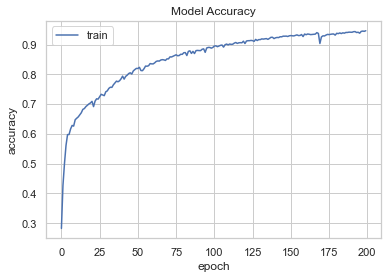

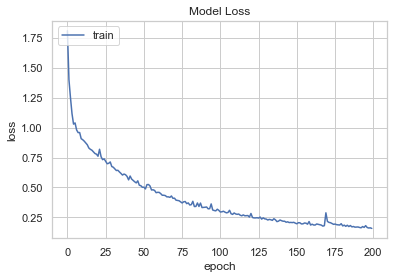

In [25]:
##########################
# # get model accuracy # #
##########################
plt.plot(history.history['accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

######################
# # get model loss # #
######################
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

#### SAVE MODEL

In [26]:
##################
# # save model # #
##################
model.model.save(MODEL_PATH)

# LIVE TESTING FOR IU
> Live test with new dataset to check if model function as it should

#### LOAD MODEL

In [27]:
##################
# # load model # #
##################

# model = create_model()
model = load_model(MODEL_PATH)

#### LOAD DATA
- Import new dataset to verify the model is able to predict accurately

In [28]:
METHOD = "IU" # identical_unique
# METHOD = "DU" # different_unique

ACTUAL_DATASET_NAME = "pair_test_" + METHOD
ACTUAL_DATASET_PATH = os.path.join(DATASET_DIR_PATH, ACTUAL_DATASET_NAME + ".csv")

RESULT_DIR_NAME = "dataset\set02\\02_pair"
RESULT_NAME = "result_" + "set02_02_pair_" + METHOD
RESULT_DIR_PATH = os.path.join(os.getcwd(), RESULT_DIR_NAME)
RESULT_PATH = os.path.join(RESULT_DIR_PATH, RESULT_NAME + ".csv")

# import unseen data
pred_df = pd.read_csv(ACTUAL_DATASET_PATH)
pred_df.head()

,Subject,Class,Sequence,T2-D|0,T2-I|0+1,T2-PF|0+1,T2-RF|0+1,T2-NG|0+1,T2-D|1,T2-I|1+2,...,T9-RF|VAR.1,T9-NG|VAR.1,T9-I|SD.1,T9-PF|SD.1,T9-RF|SD.1,T9-NG|SD.1,T10-I|0+9.1,T10-PF|0+9.1,T10-RF|0+9.1,T10-NG|0+9.1
0,adhy,3,use volume,0.138573,-0.084819,0.053754,0.084257,0.22283,0.169076,-0.100031,...,0.000478,3.870000e-09,0.022083,0.043876,0.021856,0.000062,0.802144,0.871402,0.871176,0.940435
1,adhy,3,use volume,0.138573,-0.084819,0.053754,0.084257,0.22283,0.169076,-0.100031,...,0.001097,4.876180e-04,0.044149,0.011049,0.033116,0.022082,1.119966,1.267125,1.220308,1.367467
2,adhy,3,use volume,0.138573,-0.084819,0.053754,0.084257,0.22283,0.169076,-0.100031,...,0.003094,5.096550e-04,0.011010,0.022040,0.055626,0.022576,0.904103,0.989002,0.988245,1.073144
3,adhy,3,use volume,0.138573,-0.084819,0.053754,0.084257,0.22283,0.169076,-0.100031,...,0.040961,4.824167e-02,0.179768,0.197020,0.202387,0.219640,1.311359,1.489939,1.411038,1.589618
4,adhy,3,use volume,0.138573,-0.084819,0.053754,0.084257,0.22283,0.169076,-0.100031,...,0.018903,1.890288e-02,0.093657,0.093656,0.137488,0.137488,1.119189,1.219711,1.203950,1.304473


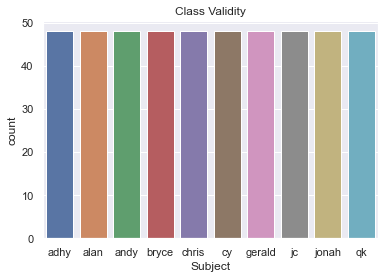

In [29]:
################################
# # check for class validity # #
################################
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="Subject", data=pred_df).set_title("Class Validity")

# remove missing values if available
pred_df = pred_df.dropna()

In [30]:
pred_dataset = pred_df.values
actual_np = pred_dataset[:,CLASSES_COL_NUM]

# # divide data into features X
# pred_row = pred_dataset[:,3:].astype(float)

########################
# # predict all rows # #
########################
pred_row=pred_df.iloc[:,FEATURES_COL_NUM:]

#################################
# # predict more than one row # #
#################################

# pred_row=pred_df.iloc[46:54,FEATURES_COL_NUM:]
# print(pred_row)

############################
# # predict a single row # #
############################

# pred_row=pred_df.iloc[11:12,FEATURES_COL_NUM:]

##################
# # shape data # #
##################
pred_row = pred_row.values.tolist()
pred_arr = np.asarray(pred_row, dtype=np.float32)
pred_arr = np.reshape(pred_arr, (pred_arr.shape[0], TIMESTEPS, pred_arr.shape[1]))

print(class_list)
Y = np.asarray(class_list)
Y = Y.reshape(-1, 1)
lb = LabelBinarizer().fit(Y)
Y = lb.transform(Y)

['adhy', 'alan', 'andy', 'bryce', 'chris', 'cy', 'gerald', 'jc', 'jonah', 'qk']


In [31]:
####################################
# # get prediction and its label # #
####################################

pred_proba = model.predict(pred_arr)

# pred_proba = np.sum(pred_proba, axis=0)
# pred_proba = np.reshape(pred_proba, (1, 9))

pred = lb.inverse_transform(pred_proba)
acc = np.max(pred_proba, axis=1)

match_list = []

for _ in range(actual_np.size):
    if pred[_] == actual_np[_]:
        match_list.append("match")
    else:
        match_list.append("nope")

match_count = match_list.count("match")
total_count = len(match_list)

match_header = str(match_count) + "/" + str(total_count) + " (" + str(match_count/total_count*100)+ "%)"
match_np = np.array(match_list)

exported_output = np.column_stack((actual_np, pred))
exported_output = np.column_stack((exported_output, acc))
exported_output = np.column_stack((exported_output, match_np))

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

df = pd.DataFrame(data=exported_output, index=None, columns=['Actual', 'Prediction', 'Accuracy', match_header])
# print(df)
df.to_csv(RESULT_PATH)

iu_result = "Accuracy of the Model for IU dataset: " + str(match_header)
print(iu_result)

Accuracy of the Model for IU dataset: 294/480 (61.25000000000001%)


# LIVE TESTING FOR DU
> Live test with new dataset to check if model function as it should

#### LOAD MODEL

In [32]:
##################
# # load model # #
##################

# model = create_model()
model = load_model(MODEL_PATH)

#### LOAD DATA
- Import new dataset to verify the model is able to predict accurately

In [33]:
# METHOD = "IU" # identical_unique
METHOD = "DU" # different_unique

DATASET_DIR_NAME = "dataset\set02\\02_pair"
ACTUAL_DATASET_NAME = "pair_test_" + METHOD
ACTUAL_DATASET_PATH = os.path.join(DATASET_DIR_PATH, ACTUAL_DATASET_NAME + ".csv")

RESULT_DIR_NAME = "dataset\set02\\02_pair"
RESULT_NAME = "result_" + "set02_02_pair_" + METHOD
RESULT_DIR_PATH = os.path.join(os.getcwd(), RESULT_DIR_NAME)
RESULT_PATH = os.path.join(RESULT_DIR_PATH, RESULT_NAME + ".csv")

# import unseen data
pred_df = pd.read_csv(ACTUAL_DATASET_PATH)
pred_df.head()

,Subject,Class,Sequence,T2-D|0,T2-I|0+1,T2-PF|0+1,T2-RF|0+1,T2-NG|0+1,T2-D|1,T2-I|1+2,T2-PF|1+2,T2-RF|1+2,T2-NG|1+2,T2-D|2,T2-I|2+3,T2-PF|2+3,T2-RF|2+3,T2-NG|2+3,T2-D|3,T2-I|3+4,T2-PF|3+4,T2-RF|3+4,T2-NG|3+4,T2-D|4,T2-I|4+5,T2-PF|4+5,T2-RF|4+5,T2-NG|4+5,T2-D|5,T2-I|5+6,T2-PF|5+6,T2-RF|5+6,T2-NG|5+6,T2-D|6,T2-I|6+7,T2-PF|6+7,T2-RF|6+7,T2-NG|6+7,T2-D|7,T2-I|7+8,T2-PF|7+8,T2-RF|7+8,T2-NG|7+8,T2-D|8,T2-I|8+9,T2-PF|8+9,T2-RF|8+9,T2-NG|8+9,T2-D|9,T2-D|S,T2-I|S,T2-PF|S,T2-RF|S,T2-NG|S,T2-D|M,T2-I|M,T2-PF|M,T2-RF|M,T2-DT-M,T2-D|VAR,T2-I|VAR,T2-PF|VAR,T2-RF|VAR,T2-DT-VAR,T2-D|SD,T2-I|SD,T2-PF|SD,T2-RF|SD,T2-NG|SD,T3-I|0+2,T3-PF|0+2,T3-RF|0+2,T3-NG|0+2,T3-I|1+3,T3-PF|1+3,T3-RF|1+3,T3-NG|1+3,T3-I|2+4,T3-PF|2+4,T3-RF|2+4,T3-NG|2+4,T3-I|3+5,T3-PF|3+5,T3-RF|3+5,T3-NG|3+5,T3-I|4+6,T3-PF|4+6,T3-RF|4+6,T3-NG|4+6,T3-I|5+7,T3-PF|5+7,T3-RF|5+7,T3-NG|5+7,T3-I|6+8,T3-PF|6+8,T3-RF|6+8,T3-NG|6+8,T3-I|7+9,T3-PF|7+9,T3-RF|7+9,T3-NG|7+9,T3-I|S,T3-PF|S,T3-RF|S,T3-NG|S,T3-I|M,T3-PF|M,T3-RF|M,T3-NG|M,T3-I|VAR,T3-PF|VAR,T3-RF|VAR,T3-NG|VAR,T3-I|SD,T3-PF|SD,T3-RF|SD,T3-NG|SD,T4-I|0+3,T4-PF|0+3,T4-RF|0+3,T4-NG|0+3,T4-I|1+4,T4-PF|1+4,T4-RF|1+4,T4-NG|1+4,T4-I|2+5,T4-PF|2+5,T4-RF|2+5,T4-NG|2+5,T4-I|3+6,T4-PF|3+6,T4-RF|3+6,T4-NG|3+6,T4-I|4+7,T4-PF|4+7,T4-RF|4+7,T4-NG|4+7,T4-I|5+8,T4-PF|5+8,T4-RF|5+8,T4-NG|5+8,T4-I|6+9,T4-PF|6+9,T4-RF|6+9,T4-NG|6+9,T4-I|S,T4-PF|S,T4-RF|S,T4-NG|S,T4-I|M,T4-PF|M,T4-RF|M,T4-NG|M,T4-I|VAR,T4-PF|VAR,T4-RF|VAR,T4-NG|VAR,T4-I|SD,T4-PF|SD,T4-RF|SD,T4-NG|SD,T5-I|0+4,T5-PF|0+4,T5-RF|0+4,T5-NG|0+4,T5-I|1+5,T5-PF|1+5,T5-RF|1+5,T5-NG|1+5,T5-I|2+6,T5-PF|2+6,T5-RF|2+6,T5-NG|2+6,T5-I|3+7,T5-PF|3+7,T5-RF|3+7,T5-NG|3+7,T5-I|4+8,T5-PF|4+8,T5-RF|4+8,T5-NG|4+8,T5-I|5+9,T5-PF|5+9,T5-RF|5+9,T5-NG|5+9,T5-I|S,T5-PF|S,T5-RF|S,T5-NG|S,T5-I|M,T5-PF|M,T5-RF|M,T5-NG|M,T5-I|VAR,T5-PF|VAR,T5-RF|VAR,T5-NG|VAR,T5-I|SD,T5-PF|SD,T5-RF|SD,T5-NG|SD,T6-I|0+5,T6-PF|0+5,T6-RF|0+5,T6-NG|0+5,T6-I|1+6,T6-PF|1+6,T6-RF|1+6,T6-NG|1+6,T6-I|2+7,T6-PF|2+7,T6-RF|2+7,T6-NG|2+7,T6-I|3+8,T6-PF|3+8,T6-RF|3+8,T6-NG|3+8,T6-I|4+9,T6-PF|4+9,T6-RF|4+9,T6-NG|4+9,T6-I|S,T6-PF|S,T6-RF|S,T6-NG|S,T6-I|M,T6-PF|M,T6-RF|M,T6-NG|M,T6-I|VAR,T6-PF|VAR,T6-RF|VAR,T6-NG|VAR,T6-I|SD,T6-PF|SD,T6-RF|SD,T6-NG|SD,T7-I|0+6,T7-PF|0+6,T7-RF|0+6,T7-NG|0+6,T7-I|1+7,T7-PF|1+7,T7-RF|1+7,T7-NG|1+7,T7-I|2+8,T7-PF|2+8,T7-RF|2+8,T7-NG|2+8,T7-I|3+9,T7-PF|3+9,T7-RF|3+9,T7-NG|3+9,T7-I|S,T7-PF|S,T7-RF|S,T7-NG|S,T7-I|M,T7-PF|M,T7-RF|M,T7-NG|M,T7-I|VAR,T7-PF|VAR,T7-RF|VAR,T7-NG|VAR,T7-I|SD,T7-PF|SD,T7-RF|SD,T7-NG|SD,T8-I|0+7,T8-PF|0+7,T8-RF|0+7,T8-NG|0+7,T8-I|1+8,T8-PF|1+8,T8-RF|1+8,T8-NG|1+8,T8-I|2+9,T8-PF|2+9,T8-RF|2+9,T8-NG|2+9,T8-I|S,T8-PF|S,T8-RF|S,T8-NG|S,T8-I|M,T8-PF|M,T8-RF|M,T8-NG|M,T8-I|VAR,T8-PF|VAR,T8-RF|VAR,T8-NG|VAR,T8-I|SD,T8-PF|SD,T8-RF|SD,T8-NG|SD,T9-I|0+8,T9-PF|0+8,T9-RF|0+8,T9-NG|0+8,T9-I|1+9,T9-PF|1+9,T9-RF|1+9,T9-NG|1+9,T9-I|S,T9-PF|S,T9-RF|S,T9-NG|S,T9-I|M,T9-PF|M,T9-RF|M,T9-NG|M,T9-I|VAR,T9-PF|VAR,T9-RF|VAR,T9-NG|VAR,T9-I|SD,T9-PF|SD,T9-RF|SD,T9-NG|SD,T10-I|0+9,T10-PF|0+9,T10-RF|0+9,T10-NG|0+9,T2-D|0.1,T2-I|0+1.1,T2-PF|0+1.1,T2-RF|0+1.1,T2-NG|0+1.1,T2-D|1.1,T2-I|1+2.1,T2-PF|1+2.1,T2-RF|1+2.1,T2-NG|1+2.1,T2-D|2.1,T2-I|2+3.1,T2-PF|2+3.1,T2-RF|2+3.1,T2-NG|2+3.1,T2-D|3.1,T2-I|3+4.1,T2-PF|3+4.1,T2-RF|3+4.1,T2-NG|3+4.1,T2-D|4.1,T2-I|4+5.1,T2-PF|4+5.1,T2-RF|4+5.1,T2-NG|4+5.1,T2-D|5.1,T2-I|5+6.1,T2-PF|5+6.1,T2-RF|5+6.1,T2-NG|5+6.1,T2-D|6.1,T2-I|6+7.1,T2-PF|6+7.1,T2-RF|6+7.1,T2-NG|6+7.1,T2-D|7.1,T2-I|7+8.1,T2-PF|7+8.1,T2-RF|7+8.1,T2-NG|7+8.1,T2-D|8.1,T2-I|8+9.1,T2-PF|8+9.1,T2-RF|8+9.1,T2-NG|8+9.1,T2-D|9.1,T2-D|S.1,T2-I|S.1,T2-PF|S.1,T2-RF|S.1,T2-NG|S.1,T2-D|M.1,T2-I|M.1,T2-PF|M.1,T2-RF|M.1,T2-DT-M.1,T2-D|VAR.1,T2-I|VAR.1,T2-PF|VAR.1,T2-RF|VAR.1,T2-DT-VAR.1,T2-D|SD.1,T2-I|SD.1,T2-PF|SD.1,T2-RF|SD.1,T2-NG|SD.1,T3-I|0+2.1,T3-PF|0+2.1,T3-RF|0+2.1,T3-NG|0+2.1,T3-I|1+3.1,T3-PF|1+3.1,T3-RF|1+3.1,T3-NG|1+3.1,T3-I|2+4.1,T3-PF|2+4.1,T3-RF|2+4.1,T3-NG|2+4.1,T3-I|3+5.1,T3-PF|3+5.1,T3-RF|3+5.1,T3-NG|3+5.1,T3-I|4+6.1,T3-PF|4+6.1,T3-RF|4+6.1,T3-NG|4+6.1,T3-I|5+7.1,T3-PF|5+7.1,T3-RF|5+7.1,T3-NG|5+7.1,T3-I|6+8.1,T3-PF|6+8.1,T3-

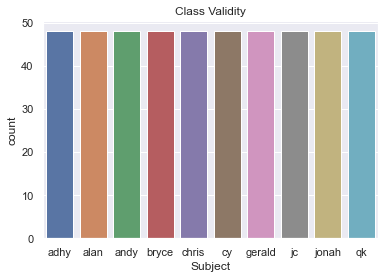

In [34]:
################################
# # check for class validity # #
################################
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="Subject", data=pred_df).set_title("Class Validity")

# remove missing values if available
pred_df = pred_df.dropna()

In [35]:
pred_dataset = pred_df.values
actual_np = pred_dataset[:,CLASSES_COL_NUM]

# # divide data into features X
# pred_row = pred_dataset[:,3:].astype(float)

########################
# # predict all rows # #
########################
pred_row=pred_df.iloc[:,FEATURES_COL_NUM:]

#################################
# # predict more than one row # #
#################################

# pred_row=pred_df.iloc[46:54,FEATURES_COL_NUM:]
# print(pred_row)

############################
# # predict a single row # #
############################

# pred_row=pred_df.iloc[11:12,FEATURES_COL_NUM:]

##################
# # shape data # #
##################
pred_row = pred_row.values.tolist()
pred_arr = np.asarray(pred_row, dtype=np.float32)
pred_arr = np.reshape(pred_arr, (pred_arr.shape[0], TIMESTEPS, pred_arr.shape[1]))

print(class_list)
Y = np.asarray(class_list)
Y = Y.reshape(-1, 1)
lb = LabelBinarizer().fit(Y)
Y = lb.transform(Y)

['adhy', 'alan', 'andy', 'bryce', 'chris', 'cy', 'gerald', 'jc', 'jonah', 'qk']


In [36]:
####################################
# # get prediction and its label # #
####################################

pred_proba = model.predict(pred_arr)

# pred_proba = np.sum(pred_proba, axis=0)
# pred_proba = np.reshape(pred_proba, (1, 9))

pred = lb.inverse_transform(pred_proba)
acc = np.max(pred_proba, axis=1)

match_list = []

for _ in range(actual_np.size):
    if pred[_] == actual_np[_]:
        match_list.append("match")
    else:
        match_list.append("nope")

match_count = match_list.count("match")
total_count = len(match_list)

match_header = str(match_count) + "/" + str(total_count) + " (" + str(match_count/total_count*100)+ "%)"
match_np = np.array(match_list)

exported_output = np.column_stack((actual_np, pred))
exported_output = np.column_stack((exported_output, acc))
exported_output = np.column_stack((exported_output, match_np))

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

df = pd.DataFrame(data=exported_output, index=None, columns=['Actual', 'Prediction', 'Accuracy', match_header])
# print(df)
df.to_csv(RESULT_PATH)

du_result = "Accuracy of the Model for DU dataset: " + str(match_header)
print(du_result)

Accuracy of the Model for DU dataset: 245/480 (51.041666666666664%)


#### RESULT

In [37]:
print(iu_result)
print(du_result)

Accuracy of the Model for IU dataset: 294/480 (61.25000000000001%)
Accuracy of the Model for DU dataset: 245/480 (51.041666666666664%)


In [38]:
# print elapsed time
elapsed_time = time.time() - start_time
print('Execution time:', time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

Execution time: 06:01:06
